[  23.48162446   10.6252058    56.88853645 ...,    1.91139068  106.44420689
  111.14446966] [ 5.05373719  3.87985705  6.78752634 ...,  2.19021339  8.36393439
  8.48527444] earthRad [ 9579543.40736708  9894693.91739956  1072720.20226288 ...,
  9837168.16462275  7240865.01121039  4113087.89054369] [ 0.12283592  0.71297803  0.6079106  ...,  0.13364571  0.31679617
  0.13868973] (25000,) (25000,) (25000,) (25000,)


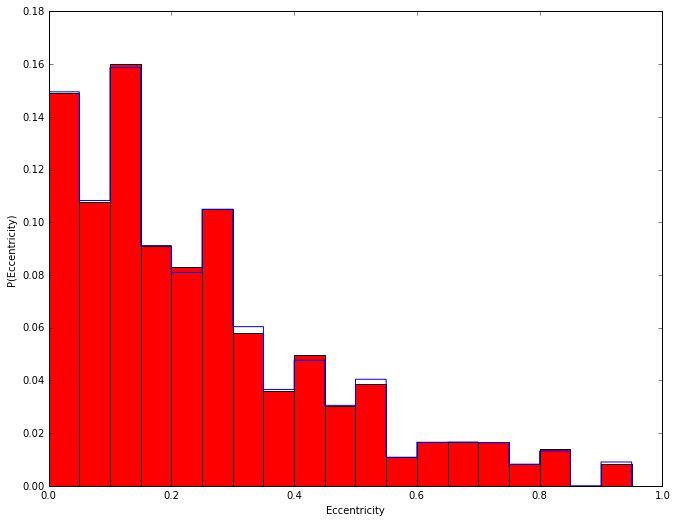

In [1]:
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

%matplotlib inline

# change the data for the kepler data, and graphs below
data = QTable.read('probecc_comma.dat',format='ascii.no_header')


data.rename_column('col1','ecc')
data.rename_column('col2','% in bin')
data.rename_column('col3','cum %')
x = np.arange(0,1,0.05)
y = data['cum %']
ecc_inbin = data['% in bin']
cum=data['cum %']
binwidth = 0.05
fig,ax=plt.subplots(1,1)
fig.set_size_inches(11,8.5)                  

bar = ax.bar(data['ecc'],ecc_inbin,width=0.05,color='r')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('P(Eccentricity)')

n = 1
ecc_list = np.array([])
while n <= 25000:
    r = (np.random.sample(1)) #some y value (percentage)
    #Tracer()()
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list=np.append(ecc_list,ecc)
    n += 1
    continue
ecc_hist = ax.hist(ecc_list,bins=x,weights=np.zeros_like(ecc_list)+1./ecc_list.size,histtype='step',color='blue')

# now to generate ICs and their files. 
# clears vars and generates new randoms
mass_list = np.array([]) #if radius < 2 R_earth, then mass = ((R/R_earth)**(3.68))*M_earth; if larger, density = 1g/cm**3
ecc = ecc_list
stellar_mass = np.random.uniform(0.7,1.4,25000) # [0.7,1.4] M_sun
stellar_radius = np.random.uniform(0.7,1.4,25000) #[0.7,1.4] R_sun
dRadius = np.random.uniform(0.5,10,25000) * u.earthRad # [0.5,10] R_earth;  
Qp = np.array([]) # [30,300] # [10**6,10**7]
Qstar = np.random.uniform(10**6,10**7,25000) # [10**6,10**7]
Period = np.array([])
semi = np.random.uniform(0.01,0.15,25000) # [0.01,0.15] AU
Ages = np.random.uniform(2*10**9,8*10**9,25000) # [2,8] Gyrs
R_crit = 2 * u.earthRad


# mass calculations
def calc_mass_l2(radius):
    r = radius
    mass = ((r/const.R_earth)**(3.68))*const.M_earth
    return mass

def calc_mass_g2(radius):
    r = radius
    r = r.to(u.cm)
    volume = (4*np.pi*r**3)/3
    density = (1*u.g)/(1*u.cm)**3
    mass = volume * density
    return mass

# determining mass and Qp based on radius
for r in dRadius:
    if r < 2*u.earthRad:
        mass = calc_mass_l2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(30,301)
    else:
        mass = calc_mass_g2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(10**6,(10**7)+1)
    mass_list = np.append(mass_list,mass.value)
    Qp = np.append(Qp,Qplanet)

        


print (mass_list,dRadius,Qp,ecc_list,mass_list.shape,dRadius.shape,Qp.shape,ecc_list.shape)


3886 21114 25000


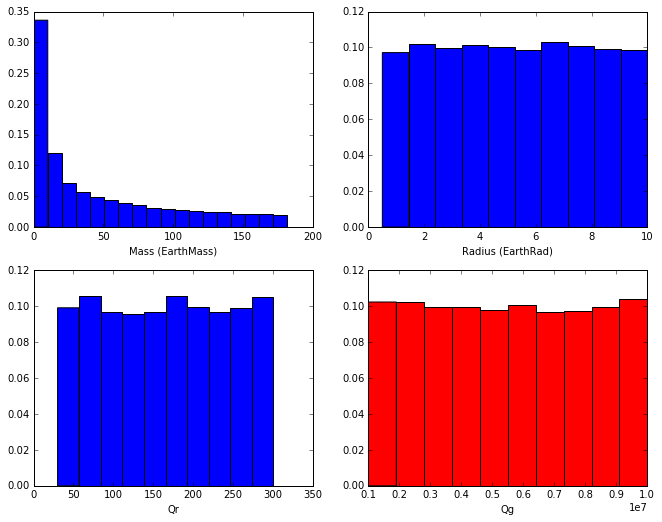

In [2]:
# now to graph above params in histograms
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_list)-min(mass_list)
ax[0,0].hist(mass_list,bins=18,weights=np.zeros_like(mass_list)+1./mass_list.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(dRadius,weights=np.zeros_like(dRadius.value)+1./dRadius.size) # Uniform
q_lower = np.where(Qp<=301)
q_upper = np.where(Qp>301) 
ax[1,0].hist(Qp[q_lower],weights=np.zeros_like(Qp[q_lower])+1./Qp[q_lower].size) 
ax[1,1].hist(Qp[q_upper],weights=np.zeros_like(Qp[q_upper])+1./Qp[q_upper].size,color='r')

ax[0,0].set_xlabel('Mass (EarthMass)')
ax[0,1].set_xlabel('Radius (EarthRad)')
ax[1,0].set_xlabel('Qr')
ax[1,1].set_xlabel('Qg')

print(Qp[q_lower].size,Qp[q_upper].size,Qp[q_lower].size + Qp[q_upper].size)

In [3]:
# Parameters still need to do, by file
# b.in
name_b = 'b'
modules_b = 'eqtide'
sTideModel = 'p2'
dMass = (mass_list)*(-1) # sets to earth masses
dRadius = (dRadius)*(-1) # sets to earth radii
bForceEqSpin = 1
#dRotPeriod = -1 
dObliquity = 0 
dRadGyra = 0.5
dTidalQ = Qp 
dK2 = 0.3
#dMaxLockDiff = 0.1 
saTidePerts = 'star'
saOutputOrder_b = 'Time Semim Ecce'

#star.in
name_star = 'star'
modules_star = 'eqtide'
dMass_star = np.random.uniform(0.7,1.4,25000) #solar masses; convert to earth masses:
dRadius_star = dMass_star
dObliquity_star = 0  
bForceEqSpin_star = 1
#dRotPeriod_star = -83 
dRadGyra_star = 0.5 
dTidalQ_star = 10**6
dK2_star = 0.3 
saTidePerts_star = 'b'
saOutputOrder_s = 'Time'

#vpl.in
Sys_name = 'system'
iVerbose = 5
bOverwrite = 1
saBodyFiles = 'star.in b.in'  
UnitMass = 'solar' 
UnitLength = 'aU'  
UnitTime = 'YEARS'
UnitAngle = 'd'
UnitTemp = 'K'
bDoLog = 1
iDigits = 6
dMinValue = 10**(-10)
bDoForward = 1
bVarDt = 1
dEta = 0.01
dStopTime = Ages
dOutputTime = 10**9

#any extra conversions for units defined in vpl.in; therefore everything needs to be in M_earth or R_earth.


In [5]:
# need to make 25000 folders, 1 to 25000; DONT RUN THIS CELL UNLESS YOU WANNA LOSE ALL YOUR RUNS
import os
import shutil
from IPython.core.debugger import Tracer
shutil.rmtree('./runs/') # removes current runs; 

n = 0
while n <= 24999: # will make n <= x amount of folders; (25000); DOESN'T FILL LAST RUN WITH CONTENT
    # make strings of values; b.in
    name_idx = str(n)
    mass_str = str(mass_list[n])
    radius_str = str(dRadius[n].value)
    eqspin_str = str(bForceEqSpin)
    obl_str = str(dObliquity)
    radgy_str = str(dRadGyra)
    ecc_str = str(ecc[n])
    semi_str = str(semi[n])
    q_str = str(dTidalQ[n])
    dK2_str = str(dK2)
    perts_str = str(saTidePerts)
    outorder_str = str(saOutputOrder_b)
    #star.in
    name_star = name_star
    modules_star = modules_star
    strMass_str = str(dMass_star[n])
    strRad_str = str(dRadius_star[n])
    strObl_str = str(dObliquity_star)
    strEqSpin_str = str(bForceEqSpin_star)
    strRadGyr_str = str(dRadGyra_star)
    strTidalQ_str = str(dTidalQ_star)
    strdK2_str = str(dK2_star)
    saTidePerts_star = saTidePerts_star
    strsaOutputOrder = saOutputOrder_s
    #vpl.in
    sys_name = Sys_name
    iVerbose_str = str(iVerbose)
    bOverwrite_str = str(bOverwrite)
    saBodyFiles = saBodyFiles
    UnitMass = UnitMass
    UnitLength = UnitLength
    UnitTime = UnitTime
    UnitAngle = UnitAngle
    UnitTemp = UnitTemp
    bDoLog_str = str(bDoLog)
    iDigits_str = str(iDigits)
    dMinValue_str = str(dMinValue)
    bDoForward_str = str(bDoForward)
    bVarDt_str = str(bVarDt)
    dEta_str = str(dEta)
    dStopTime_str = str(int(dStopTime[n]))
    dOutputTime_str = str(dOutputTime)
    
    os.makedirs('./runs/'+name_idx)
    b = open('./runs/'+name_idx+'/b.in','w')
    b_content = 'sName\t'+ name_b + '\nsaModules\t'+modules_b+'\nsTideModel\t'+sTideModel+'\ndMass\t'+mass_str+'\ndRadius\t'+radius_str+'\ndObliquity\t'+obl_str+'\ndRadGyra\t'+radgy_str+'\n\ndEcc\t'+ecc_str+'\ndSemi\t'+semi_str+'\n\nbForceEqSpin\t'+eqspin_str+'\ndTidalQ\t'+q_str+'\ndK2\t'+dK2_str+'\nsaTidePerts\t'+perts_str+'\n\nsaOutputOrder\t'+outorder_str+'\n'
    b.write(b_content)
    
    star = open('./runs/'+name_idx+'/star.in','w')
    star_content = 'sName\t'+name_star+'\nsaModules\t'+modules_star+'\n\ndMass\t'+strMass_str+'\ndRadius\t'+strRad_str+'\ndObliquity\t'+strObl_str+'\nbForceEqSpin\t'+strEqSpin_str+'\ndRadGyra\t'+strRadGyr_str+'\n\ndTidalQ\t'+strTidalQ_str+'\ndK2\t'+strdK2_str+'\n\nsaTidePerts\t'+saTidePerts_star+'\n\nsaOutputOrder\t'+strsaOutputOrder+'\n'
    star.write(star_content)
    
    vpl = open('./runs/'+name_idx+'/vpl.in','w')
    vpl_content = 'sSystemName\t'+sys_name+'\niVerbose\t'+iVerbose_str+'\nbOverwrite\t'+bOverwrite_str+'\n\nsaBodyFiles\t'+saBodyFiles+'\n\nsUnitMass\t'+UnitMass+'\nsUnitLength\t'+UnitLength+'\nsUnitTime\t'+UnitTime+'\nsUnitAngle\t'+UnitAngle+'\nsUnitTemp\t'+UnitTemp+'\n\nbDoLog\t'+bDoLog_str+'\niDigits\t'+iDigits_str+'\ndMinValue\t'+dMinValue_str+'\n\nbDoForward\t'+bDoForward_str+'\nbVarDt\t'+bVarDt_str+'\ndEta\t'+dEta_str+'\ndStopTime\t'+dStopTime_str+'\ndOutputTime\t'+ dOutputTime_str+'\n'
    vpl.write(vpl_content)
    
    n += 1
    
    
    


cd = os.getcwd()





In [ ]:
# now to run all of them!!
import subprocess
import os


s = 0 
while s <= 24999:
    folder_name = str(s)
    working_directory= './runs/'+folder_name
    p = subprocess.Popen(['vplanet vpl.in'], shell=True,cwd=working_directory)
    p.wait()
    n += 1
    continue

    
# questions
# all merging
# not putting in content for folder 24999
# cant compile on laptop

In [ ]:

# Sanity check, pick some range of y and spit out x and compare to original 
'''
to create cumdist, need a line where x is 0 to 1 and y is 0 to 1. 
each point is the sum of all the previous points (the third column in the data)
'''
fig,ax=plt.subplots(1,1)
x = np.arange(0,1,0.05)
y = data['cum %']
#y = np.array(y)
ax.plot(x,y,c='blue')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('% below given X')

#sanity check


    
    
r = (np.random.sample(1))
if r >= 0.25 and r <= 0.75:
    r_mask = np.where(y<=r)
else:
    r_mask = np.where(y==y) # doesnt apply any masking, x_below = x
    
x_below = x[r_mask]
x_below = np.append(x_below,x_below[-1]+0.05) # to include the bin in which r belongs
max_index = np.argmax(x_below) 
max_range = x_below[-1]


# now set r = y and find all values of x that are less than that percent
#now add (% in bin) up to b_max, and compare cumsum 
sanity_check = np.cumsum(ecc_inbin[0:max_index+1])
print(r,'=r','\n',r_mask,'=r_mask(indices)','\n',x_below,'bins(last is right edge)','\n',max_index,'index of right edge','\n',sanity_check)

In [ ]:
# make 25000 ICs w/ mass, radii, Q, ecc., period and histogram of each; 25 bins per parameter
# in data, the last column is upper bound for the bin, where bin_upper is the next line's eccentricity
    #ex --> first line means 14.9% are below 0.05
#DATA MATCHES!!!!!
#25000 folders
#np.random.uniform() for all except eccentricity.
#import subprocess. 
#size of output files
#output time 1gyr
#eqtide
#ecc + binwidth
    #get bin, then plus random number in binwidth. 

In [ ]:
# generate eccentricity distribution mirroring above histogram
from IPython.core.debugger import Tracer
n = 1
ecc_list = np.array([])
while n <= 25000:
    r = (np.random.sample(1)) #some y value (percentage)
    #Tracer()()
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list=np.append(ecc_list,ecc)
    n += 1
    continue
too_big = np.where(x>1)
np.delete(ecc_list,ecc_list[too_big])
print (ecc_list,ecc_list[too_big].shape)
fig,ax = plt.subplots(1,1)
plt.hist(ecc_list,bins=20,weights=np.zeros_like(ecc_list)+1./ecc_list.size)

In [ ]:
#tests for correlation between dRadius and Masses: GOOD!


t=(4.333 * u.earthRad) #r > 2
t.to(u.cm)
volume = (4 * np.pi * t**3)/3
density = (1*u.g)/(1*u.cm)**3
mass = volume * density
mass = mass.to(u.earthMass)

y = (0.5184273 * u.earthRad) # r < 2
#mass = (y/const.R_earth)**(3.68)*const.M_earth
#mass=mass.to(u.earthMass)
mass

In [2]:
starmass = 0.7 * u.M_sun
starmass = starmass.to(u.M_earth)
starmass

<Quantity 233063.8411837568 earthMass>